# <center>Stock Market Prediction</center>


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, pytz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
from subprocess import check_output

from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import xgboost as xgb
from xgboost import plot_importance, plot_tree
# from fbprophet import Prophet
plt.style.use('fivethirtyeight')

### Abstract

This project investigates the applicability of machine learning methods to forecasting price movements in Stock Market. Stock Market predictions have historically been a problem tackled by different singular approaches even though markets are influenced by many different factors. The proposed model leverages XGBoost to predict a stock price, long short-term memory (LSTM) and ARIMA approach to predict a multiplier. Sentiment analysis is then used to capture the impact of various factors on stock prices, including market trends, economic indicators, and public opinion. The results of the model are compared to traditional prediction models using historical stock data, and it is shown that the proposed model provides improved accuracy in predicting future stock prices. The proposed model represents a significant step forward in stock price prediction, providing a more comprehensive and effective approach to predicting stock prices based on multiple factors.

In [3]:
# dji_df = yf.download('DJI', start='2022-01-01', interval='1h')

In [4]:
stock_symbol = '^DJI'

# Set the time period
start_date = '1992-01-01'
end_date = '2023-10-31'
split_date = '01-Jan-2020'

# Get the data for the stock
stock_data = yf.Ticker(stock_symbol)

# Fetch the historical prices for the chosen time period
stock_df = stock_data.history(start=start_date, end=end_date)

stock_df.reset_index(inplace=True)

# Add a new column that replaces the index column
stock_df['Weighted_Price'] = (stock_df['Open'] + stock_df['Low'] + stock_df['High'] + 2 * stock_df['Close']) / 5

In [5]:
stock_df.index

RangeIndex(start=0, stop=8017, step=1)

In [6]:
stock_df.head() 

Date         Open         High          Low  \
0 1992-01-02 00:00:00-05:00  3152.100098  3172.629883  3139.310059   
1 1992-01-03 00:00:00-05:00  3172.399902  3210.639893  3165.919922   
2 1992-01-06 00:00:00-05:00  3201.500000  3213.330078  3191.860107   
3 1992-01-07 00:00:00-05:00  3200.100098  3210.199951  3184.479980   
4 1992-01-08 00:00:00-05:00  3204.800049  3229.199951  3185.820068   

         Close    Volume  Dividends  Stock Splits  Weighted_Price  
0  3172.399902  23550000        0.0           0.0     3161.767969  
1  3201.500000  23620000        0.0           0.0     3190.391943  
2  3200.100098  27280000        0.0           0.0     3201.378076  
3  3204.800049  25510000        0.0           0.0     3200.876025  
4  3203.899902  29040000        0.0           0.0     3205.523975

In [7]:
stock_df.shape

(8017, 9)

In [8]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8017 entries, 0 to 8016
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype                           
---  ------          --------------  -----                           
 0   Date            8017 non-null   datetime64[ns, America/New_York]
 1   Open            8017 non-null   float64                         
 2   High            8017 non-null   float64                         
 3   Low             8017 non-null   float64                         
 4   Close           8017 non-null   float64                         
 5   Volume          8017 non-null   int64                           
 6   Dividends       8017 non-null   float64                         
 7   Stock Splits    8017 non-null   float64                         
 8   Weighted_Price  8017 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(7), int64(1)
memory usage: 563.8 KB


In [9]:
#First replace N/A value if exist with zero

stock_df['Volume'].fillna(value=0, inplace=True)
stock_df['Dividends'].fillna(value=0, inplace=True)
stock_df['Stock Splits'].fillna(value=0, inplace=True)


# next need to fix the (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
stock_df['Open'].fillna(method='ffill', inplace=True)
stock_df['High'].fillna(method='ffill', inplace=True)
stock_df['Low'].fillna(method='ffill', inplace=True)
stock_df['Close'].fillna(method='ffill', inplace=True)

stock_df.head()

Date         Open         High          Low  \
0 1992-01-02 00:00:00-05:00  3152.100098  3172.629883  3139.310059   
1 1992-01-03 00:00:00-05:00  3172.399902  3210.639893  3165.919922   
2 1992-01-06 00:00:00-05:00  3201.500000  3213.330078  3191.860107   
3 1992-01-07 00:00:00-05:00  3200.100098  3210.199951  3184.479980   
4 1992-01-08 00:00:00-05:00  3204.800049  3229.199951  3185.820068   

         Close    Volume  Dividends  Stock Splits  Weighted_Price  
0  3172.399902  23550000        0.0           0.0     3161.767969  
1  3201.500000  23620000        0.0           0.0     3190.391943  
2  3200.100098  27280000        0.0           0.0     3201.378076  
3  3204.800049  25510000        0.0           0.0     3200.876025  
4  3203.899902  29040000        0.0           0.0     3205.523975

Creating Weekly Rows for the better Data Visualization

In [10]:
# create valid date range
start = datetime.datetime(1992, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2023, 10, 31, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = stock_df[(stock_df['Date'] >= start) & (stock_df['Date'] <= end)].groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
weekly_rows.head()

Date         Open         High          Low  \
0 1992-01-06 00:00:00-05:00  3152.100098  3172.629883  3139.310059   
1 1992-01-13 00:00:00-05:00  3200.100098  3210.199951  3184.479980   
2 1992-01-20 00:00:00-05:00  3185.600098  3248.879883  3182.919922   
3 1992-01-27 00:00:00-05:00  3254.000000  3254.469971  3215.340088   
4 1992-02-03 00:00:00-05:00  3240.600098  3275.489990  3239.939941   

         Close    Volume  Dividends  Stock Splits  Weighted_Price  
0  3172.399902  23550000        0.0           0.0     3161.767969  
1  3204.800049  25510000        0.0           0.0     3200.876025  
2  3246.199951  24220000        0.0           0.0     3221.959961  
3  3223.399902  24160000        0.0           0.0     3234.121973  
4  3272.100098  24960000        0.0           0.0     3260.046045

In the bottom graph we see historical prices plotted for the entire period. The Global Financial Crisis and Covid-19 marked two of the biggest shocks in the market. In this case they will only be noted, not excluded from the model, as they have had quite a large impact on the market for quite some time to come.

In [11]:
# Create a DataFrame
df = pd.DataFrame(weekly_rows)
df['Date'] = pd.to_datetime(df['Date'])  # Convert the 'Date' column to datetime format

# Create traces for Open, High, and Close
trace_open = go.Scatter(x=df['Date'], y=df['Open'], mode='markers', name='Open')
trace_high = go.Scatter(x=df['Date'], y=df['High'], mode='markers', name='High')
trace_close = go.Scatter(x=df['Date'], y=df['Close'], mode='markers', name='Close')
# trace_wp = go.Scatter(x=df['Date'], y=df['Weighted_Price'], mode='markers', name='Weighted Price')

# Create traces for the vertical lines representing the GFC and COVID-19 effects
gfc_date = pd.to_datetime('2009-03-01')
covid_effect_date = pd.to_datetime('2020-03-01')

trace_gfc_effect = go.Scatter(
    x=[gfc_date, gfc_date],
    y=[min(df['Open']), max(df['High'])],
    mode='lines',
    line=dict(color='orange', dash='dash'),
    name='Global Financial Crisis (GFC) Effect'
)

trace_covid_effect = go.Scatter(
    x=[covid_effect_date, covid_effect_date],
    y=[min(df['Open']), max(df['High'])],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='COVID-19 Effect'
)

# Create layout
layout = go.Layout(
    title='Historical Dow Jones Prices',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis=dict(title='Stock Price'),
)

# Create the figure
fig = go.Figure(data=[trace_open, trace_high, trace_close, trace_gfc_effect, trace_covid_effect], layout=layout)

# Show the plot
fig.show()


In [12]:
# Create a DataFrame
df = pd.DataFrame(weekly_rows)
df['Date'] = pd.to_datetime(df['Date'])  # Convert the 'Date' column to datetime format

# Create a trace for the volume
trace_volume = go.Scatter(x=df['Date'], y=df['Volume'], mode='lines', name='Volume', line=dict(color='green'))

# Create traces for the vertical lines representing the GFC and COVID-19 effects
gfc_date = pd.to_datetime('2007-01-01')
covid_effect_date = pd.to_datetime('2020-03-01')

trace_gfc_effect = go.Scatter(
    x=[gfc_date, gfc_date],
    y=[min(df['Volume']), max(df['Volume'])],
    mode='lines',
    line=dict(color='orange', dash='dash'),
    name='Global Financial Crisis (GFC) Effect'
)

trace_covid_effect = go.Scatter(
    x=[covid_effect_date, covid_effect_date],
    y=[min(df['Volume']), max(df['Volume'])],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name='COVID-19 Effect'
)

# Create layout
layout = go.Layout(
    title='Stock Market Volume with GFC and COVID-19 Effects',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Volume'),
)

# Create the figure
fig = go.Figure(data=[trace_volume, trace_gfc_effect, trace_covid_effect], layout=layout)

# Show the plot
fig.show()


#### Time Series Forecasting

Predicting using LSTM

In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [13]:
data = stock_df[['Date','Weighted_Price']]

In [14]:
data.head()

Date  Weighted_Price
0 1992-01-02 00:00:00-05:00     3161.767969
1 1992-01-03 00:00:00-05:00     3190.391943
2 1992-01-06 00:00:00-05:00     3201.378076
3 1992-01-07 00:00:00-05:00     3200.876025
4 1992-01-08 00:00:00-05:00     3205.523975

In [15]:
data.shape

(8017, 2)

In [16]:
# split data
data_train = data.loc[data['Date'] <= split_date].copy()
data_test = data.loc[data['Date'] > split_date].copy()


In [17]:
data_train.set_index('Date', inplace=True)

In [18]:
data_test.set_index('Date', inplace=True)

In [19]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Weighted_Price'], mode='lines', name='Weighted Price'))
fig.update_layout(title='Weighted Price Over Time', xaxis_title='Datetime', yaxis_title='Weighted Price USD')
fig.show()

In [21]:
# Plot the data using go.Scatter with different colors
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Weighted_Price'], mode='lines' ,name='Train set', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Weighted_Price'], mode='lines', name='Test set', line=dict(color='blue')))
fig.update_layout(title='Dow Jones Weighted price ', xaxis_title='Time', yaxis_title='USD $')
fig.add_vline(x=split_date, line_dash="dash", line_color="red") #To be adjust
fig.show()


In [22]:
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
142/142 - 2s - loss: 0.1207 - 2s/epoch - 16ms/step
Epoch 2/100
142/142 - 0s - loss: 0.0656 - 475ms/epoch - 3ms/step
Epoch 3/100
142/142 - 0s - loss: 0.0517 - 491ms/epoch - 3ms/step
Epoch 4/100
142/142 - 0s - loss: 0.0423 - 490ms/epoch - 3ms/step
Epoch 5/100
142/142 - 1s - loss: 0.0351 - 507ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 0.0282 - 506ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 0.0240 - 530ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 0.0203 - 543ms/epoch - 4ms/step
Epoch 9/100
142/142 - 0s - loss: 0.0182 - 499ms/epoch - 4ms/step
Epoch 10/100
142/142 - 0s - loss: 0.0155 - 478ms/epoch - 3ms/step
Epoch 11/100
142/142 - 1s - loss: 0.0137 - 501ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 0.0118 - 509ms/epoch - 4ms/step
Epoch 13/100
142/142 - 1s - loss: 0.0107 - 522ms/epoch - 4ms/step
Epoch 14/100
142/142 - 1s - loss: 0.0096 - 517ms/epoch - 4ms/step
Epoch 15/100
142/142 - 0s - loss: 0.0089 - 489ms/epoch - 3ms/step
Epoch 16/100
142/142 

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_stock_price = model.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

31/31 [==============================] - 0s 2ms/step


In [25]:
data_test['Weighted_Price_Prediction'] = predicted_stock_price
data_all = pd.concat([data_test, data_train], sort=False)

In [26]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Date','Weighted_Price','lstm']]

<Axes: xlabel='Date'>

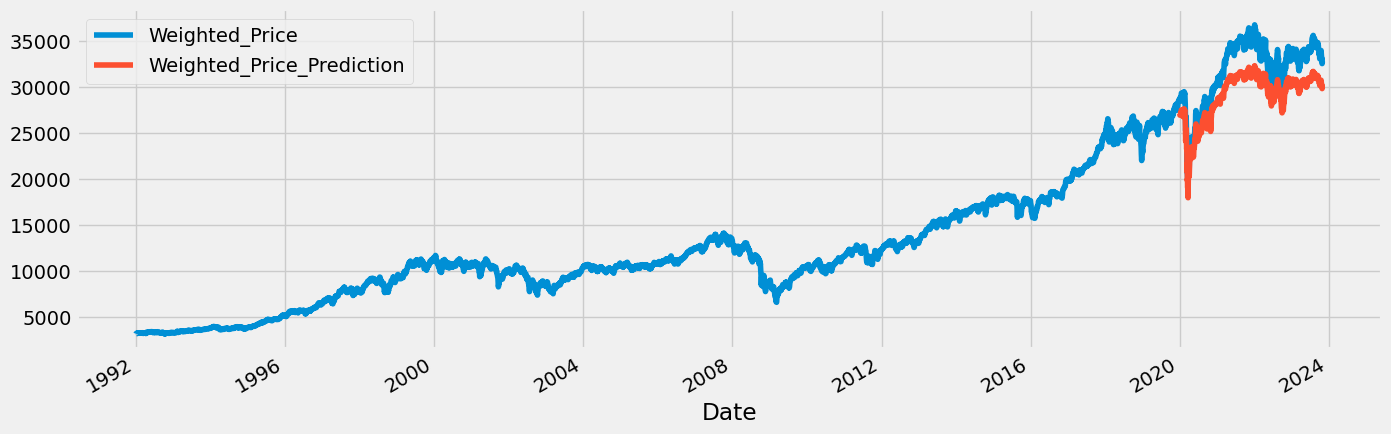

In [27]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))


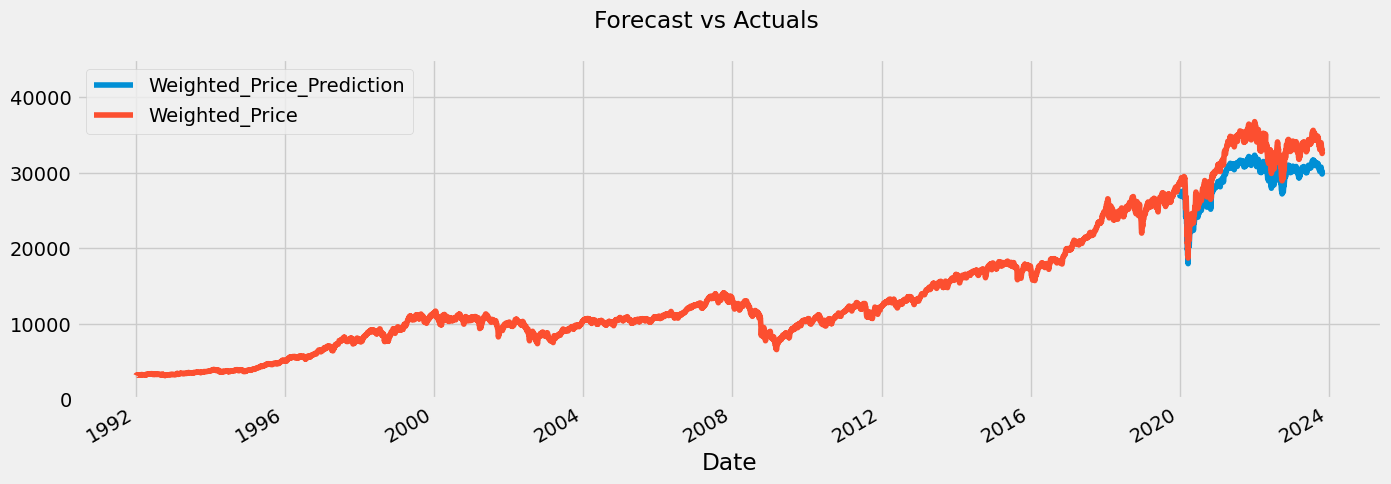

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Weighted_Price_Prediction','Weighted_Price']].plot(ax=ax,
                                              style=['-','-'])
ax.set_ylim(0, 45000)
plot = plt.suptitle('Forecast vs Actuals')

In [29]:
round(mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction']), 2)

7997386.09

In [30]:
round(mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction']), 2)

2682.58

Time Series forecasting with XGBoost

In [31]:
data = stock_df[['Date','Weighted_Price']]

In [32]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Weighted_Price'], mode='lines', name='Weighted Price'))
fig.update_layout(title='Weighted Price', xaxis_title='Date', yaxis_title='Weighted Price USD')
fig.show()

In [33]:
data_train = data.loc[data['Date'] <= split_date].copy()
data_test = data.loc[data['Date'] > split_date].copy()
data_train.set_index('Date', inplace=True)
data_test.set_index('Date', inplace=True)

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Weighted_Price'], mode='lines' ,name='Train set', line=dict(color='green')))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Weighted_Price'], mode='lines', name='Test set', line=dict(color='blue')))
fig.update_layout(title='Dow Jones Weighted price ', xaxis_title='Time', yaxis_title='USD $')
fig.show()


In [35]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth',]]
    if label:
        y = df[label]
        return X, y
    return X

In [36]:
X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

Here we use a basic XGBRegressor model,

In [37]:
# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
# #         early_stopping_rounds=50,
#        verbose=False) # Change verbose to True if you want to see it train




model =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds=50,
       verbose=True)

[0]	validation_0-rmse:5878.58745	validation_1-rmse:20402.50140
[1]	validation_0-rmse:5304.61120	validation_1-rmse:18965.18234
[2]	validation_0-rmse:5304.60697	validation_1-rmse:18965.15452
[3]	validation_0-rmse:4788.26765	validation_1-rmse:17674.21846
[4]	validation_0-rmse:4787.53300	validation_1-rmse:17674.98520
[5]	validation_0-rmse:4324.34700	validation_1-rmse:16515.83869
[6]	validation_0-rmse:3908.60996	validation_1-rmse:15475.34532
[7]	validation_0-rmse:3907.20528	validation_1-rmse:15477.29289
[8]	validation_0-rmse:3906.10366	validation_1-rmse:15478.90282
[9]	validation_0-rmse:3530.20793	validation_1-rmse:14556.88971
[10]	validation_0-rmse:3529.07229	validation_1-rmse:14558.39888
[11]	validation_0-rmse:3528.76200	validation_1-rmse:14558.78045
[12]	validation_0-rmse:3527.82075	validation_1-rmse:14560.25460
[13]	validation_0-rmse:3527.51515	validation_1-rmse:14560.64290
[14]	validation_0-rmse:3527.27547	validation_1-rmse:14560.98044
[15]	validation_0-rmse:3191.27869	validation_1-rms

XGBRegressor(alpha=10, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [38]:
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

#adding to final data for comparision
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'xgboost'})
final_data = final_data[['Date','Weighted_Price','lstm','xgboost']]

Feature Importances

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that year was most commonly used to split trees, while day of year came in next. Quarter has low importance due to the fact that it could be created by different day of year splits.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

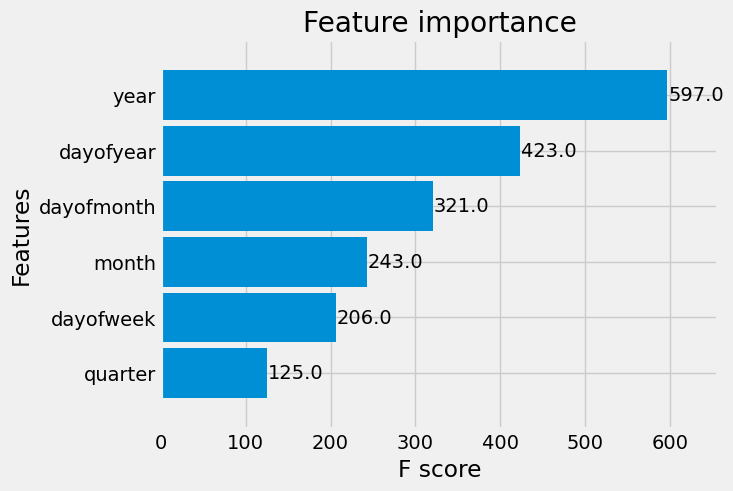

In [39]:
plot_importance(model, height=0.9)

Forecast on Test Set

In [40]:
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

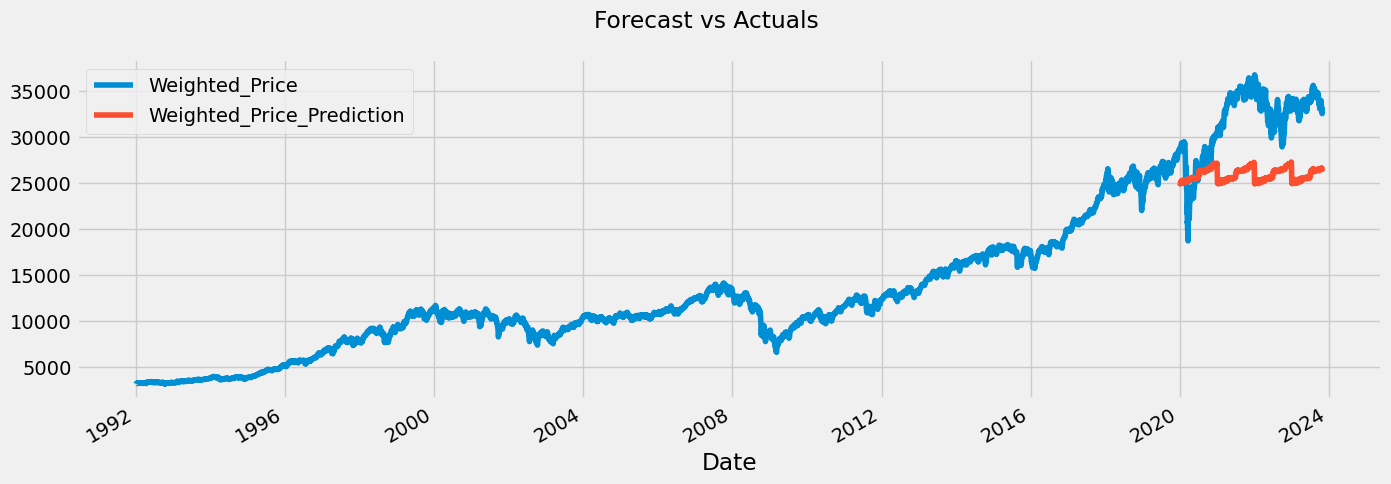

In [41]:
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(15, 5))
plot = plt.suptitle('Forecast vs Actuals')

Look at first month of predictions


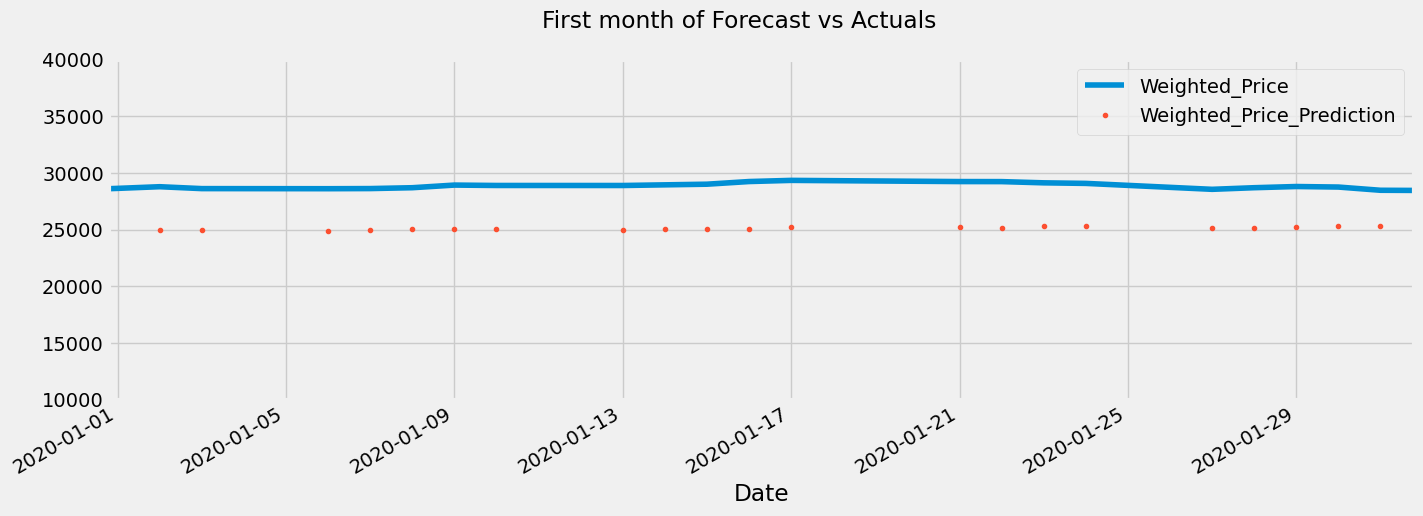

In [42]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2020-01-01', upper='2020-02-01')
ax.set_ylim(10000, 40000)
plot = plt.suptitle('First month of Forecast vs Actuals')

In [43]:
MSE = mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

In [44]:
MAE = mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
MAPE = mean_absolute_percentage_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

#### Error Metrics On Test Set

In [47]:
print(f'MSE error is {MSE:.2f}')
print(f'MAE error is {MAE:.2f}')
print(f'MAPE error is {MAPE:.2f}%')

MSE error is 46520657.65
MAE error is 6168.65
MAPE error is 18.67%


In [48]:
data_test['error'] = data_test['Weighted_Price'] - data_test['Weighted_Price_Prediction']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Weighted_Price','Weighted_Price_Prediction','error','abs_error']]

In [49]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Weighted_Price  Weighted_Price_Prediction        error  \
year month dayofmonth                                                           
2020 3     23            18709.375781               25230.267578 -6520.891797   
           20            19645.328125               25375.673828 -5730.345703   
           18            19878.664062               25381.158203 -5502.494141   
           19            19924.830078               25397.281250 -5472.451172   
           24            20303.791797               25214.187500 -4910.395703   
           16            20635.861719               25270.724609 -4634.862891   
           17            20844.684375               25168.484375 -4323.800000   
     4     1             21077.214062               25307.490234 -4230.276172   
           3             21140.377734               25307.269531 -4166.891797   
           2             21171.825781               25306.515625 -4134.689844   

                         abs_error  
year month dayofmonth               
2020 3     23          6520.891797  
           20          5730.345703  
           18          5502.494141  
           19          5472.451172  
           24          4910.395703  
           16          4634.862891  
           17          4323.800000  
     4     1           4230.276172  
           3           4166.891797  
           2           4134.689844

In [50]:
final_data.head()

Date  Weighted_Price          lstm       xgboost
0 2020-01-02 00:00:00-05:00    28775.428516  27069.998047  24978.958984
1 2020-01-03 00:00:00-05:00    28607.952344  26936.802734  24945.005859
2 2020-01-06 00:00:00-05:00    28599.782422  26930.283203  24893.917969
3 2020-01-07 00:00:00-05:00    28611.463672  26939.605469  24974.179688
4 2020-01-08 00:00:00-05:00    28687.001953  26999.779297  25008.052734

In [51]:
trace0 = go.Scatter(
    x = final_data['Date'],
    y = final_data['Weighted_Price'],
    mode = 'lines+markers',
    name = 'Weighted Price'
)
trace1 = go.Scatter(
    x = final_data['Date'],
    y = final_data['lstm'],
    mode = 'lines+markers',
    name = 'LSTM Prediction'
)
trace2 = go.Scatter(
    x = final_data['Date'],
    y = final_data['xgboost'],
    mode = 'lines+markers',
    name = 'XGBoost Prediction'
)

# Edit the layout
layout = dict(title = 'Comparision of LSTM and XGBoost with real price(Weighted Price)',
              xaxis = dict(title = 'Month'),
              yaxis = dict(title = 'Prices (USD)'),
              )

data = [trace0, trace1, trace2]
fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')

Time Series forecasting using ARIMA

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
ARIMA is one of the mostly used techniques for Time Series analysis. In Python, ARIMA based forecasting models can be created either using AutoARIMA(Pyramid ARIMA) or StatsModel . 

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'], y=data['Weighted_Price'], mode='lines', name='Weighted Price'))
fig.update_layout(title='Weighted Price', xaxis_title='Datetime', yaxis_title='Weighted Price USD')
fig.show()

TypeError: list indices must be integers or slices, not str

In [55]:
data = stock_df
data.fillna(0, inplace=True)

In [56]:
# Unix-time to 
data.Timestamp = pd.to_datetime(data['Date'], unit='s')

# Resampling to daily frequency
data.index = data.Timestamp
data_d = data.resample('D').mean()

# Resampling to monthly frequency
data_month = data.resample('M').mean()

# Resampling to annual frequency
data_year = data.resample('A-DEC').mean()

# Resampling to quarterly frequency
data_Q = data.resample('Q-DEC').mean()

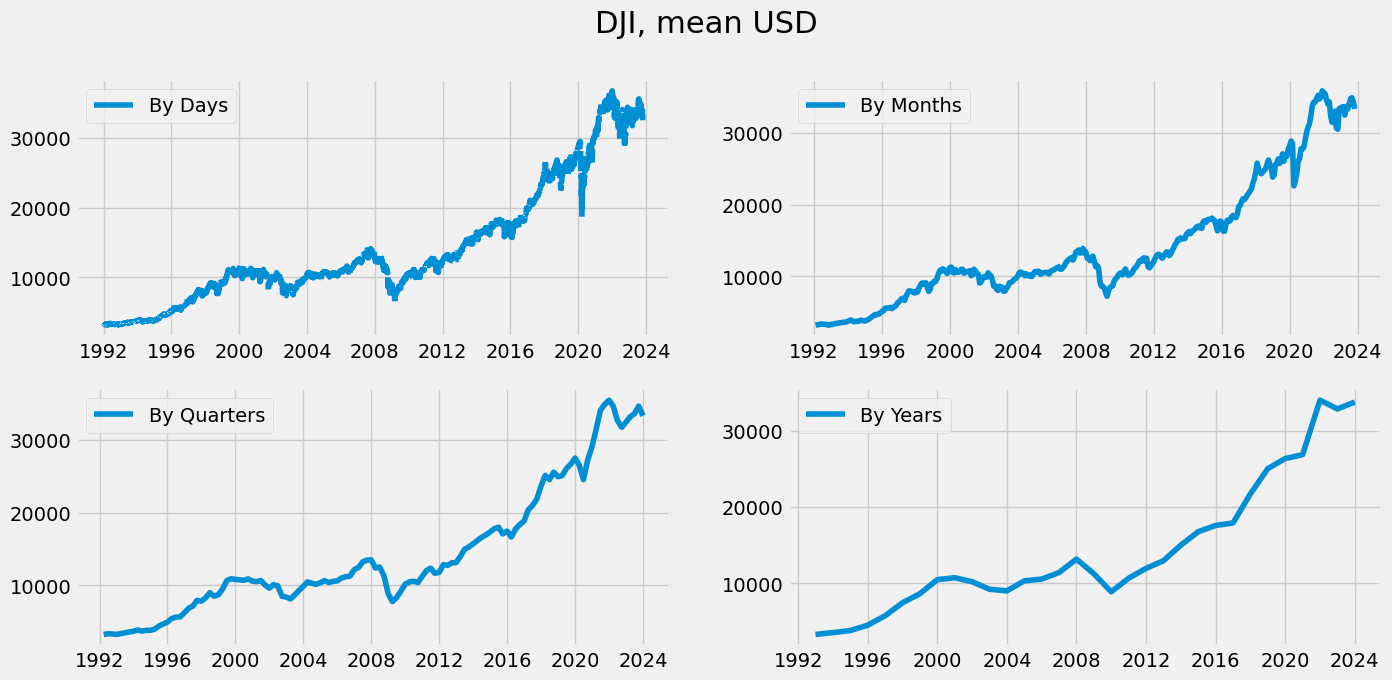

In [57]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('DJI, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(data_d['Weighted_Price'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(data_month['Weighted_Price'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(data_Q['Weighted_Price'], '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(data_year['Weighted_Price'], '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.993150


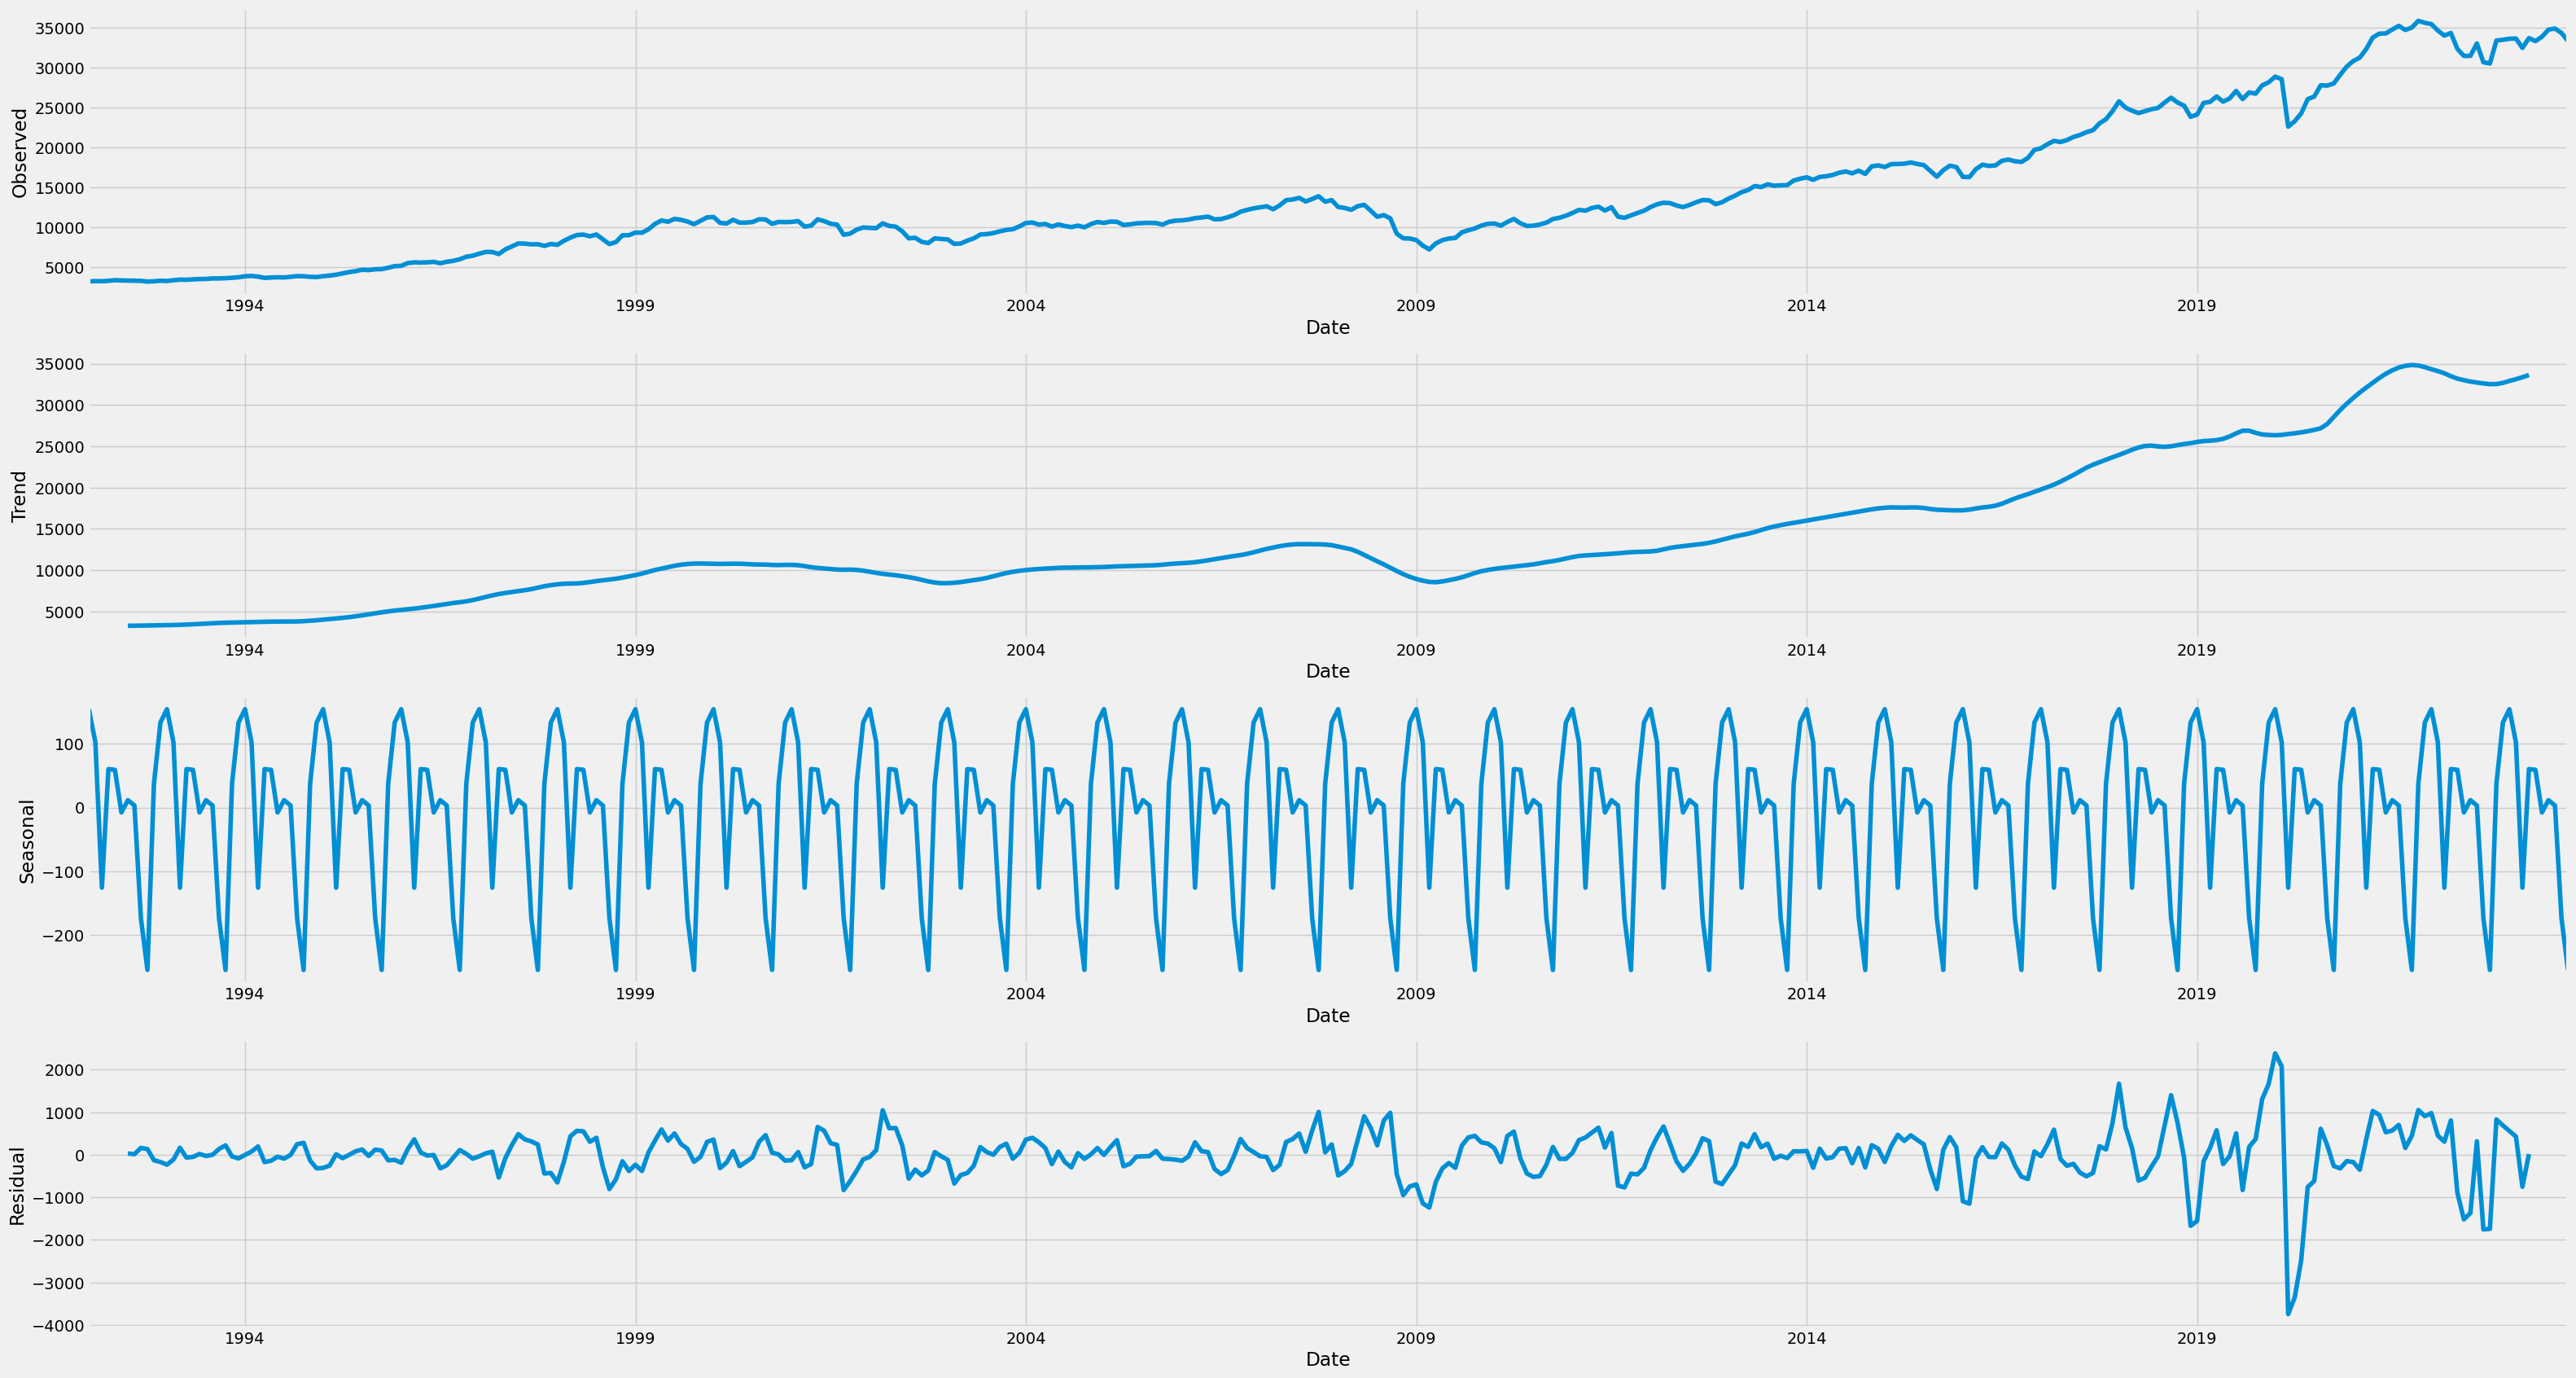

In [58]:
#Check how to plot data_month
result = sm.tsa.seasonal_decompose(data_month['Weighted_Price'], model='additive') 

# Plotting the decomposition components with adjusted size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(35, 20))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month['Weighted_Price'])[1])
# Display the plot
plt.show()

In [59]:
# Box-Cox Transformations
data_month['Weighted_Price_box'], lmbda = stats.boxcox(data_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.993150


In [60]:
# Seasonal differentiation
data_month['prices_box_diff'] = data_month.Weighted_Price_box - data_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.021363


Dickey–Fuller test: p=0.000000


<Figure size 5000x3000 with 0 Axes>

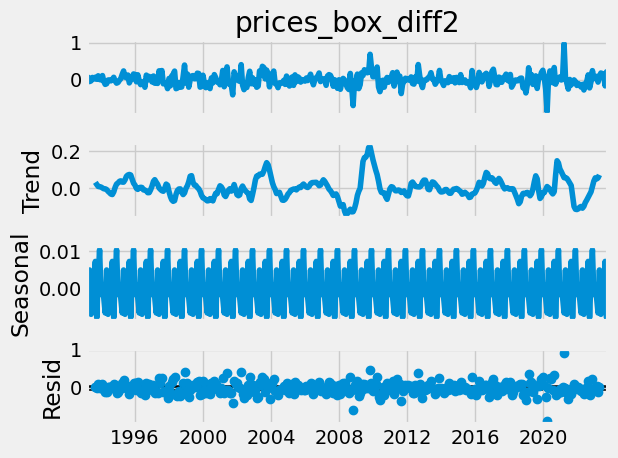

In [61]:
# Regular differentiation
data_month['prices_box_diff2'] = data_month.prices_box_diff - data_month.prices_box_diff.shift(1)
plt.figure(figsize=(50,30))

# STL-decomposition
sm.tsa.seasonal_decompose(data_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_month.prices_box_diff2[13:])[1])

plt.show()

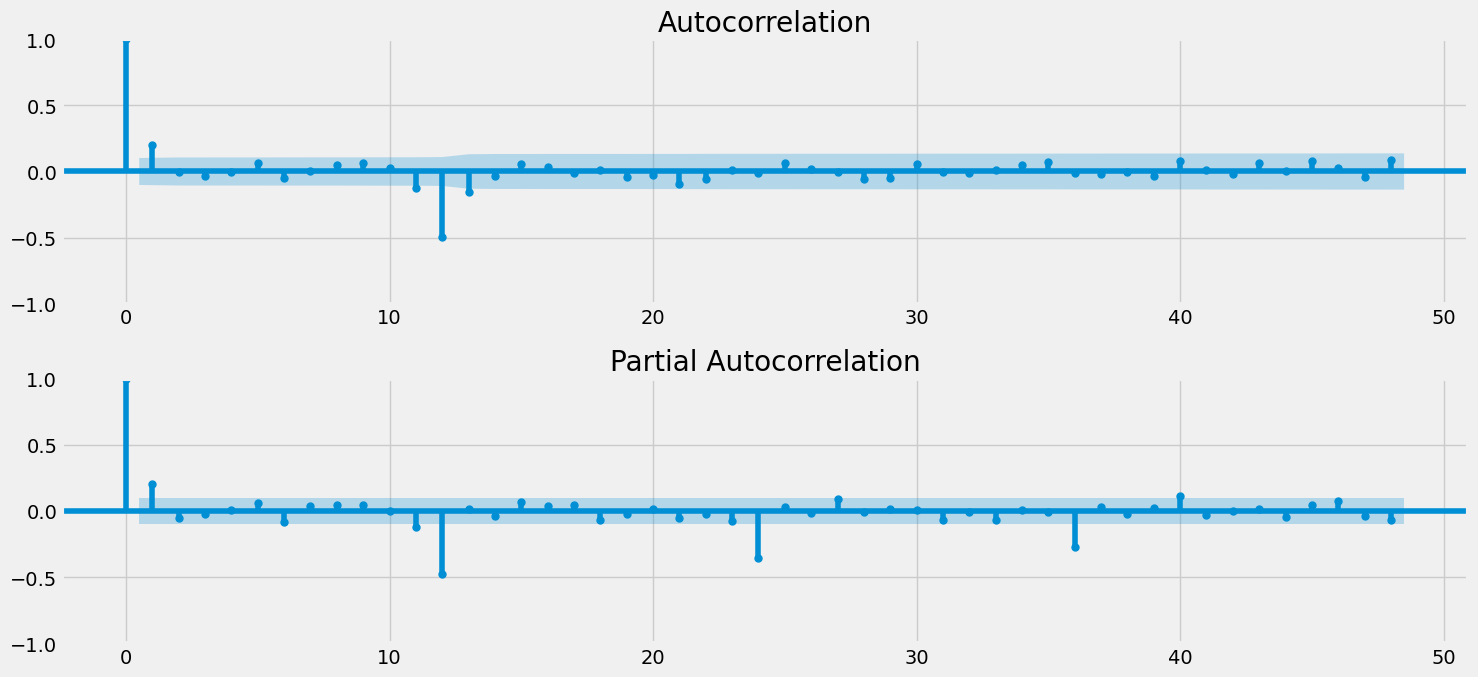

In [62]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [63]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(data_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [64]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
7   (0, 1, 0, 1) -507.839147
25  (1, 1, 0, 1) -507.769276
13  (0, 2, 0, 1) -506.905846
19  (1, 0, 0, 1) -506.774367
37  (2, 0, 0, 1) -506.609672
                                     SARIMAX Results                                      
Dep. Variable:                 Weighted_Price_box   No. Observations:                  382
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 256.920
Date:                            Mon, 13 Nov 2023   AIC                           -507.839
Time:                                    22:49:50   BIC                           -496.107
Sample:                                01-31-1992   HQIC                          -503.178
                                     - 10-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


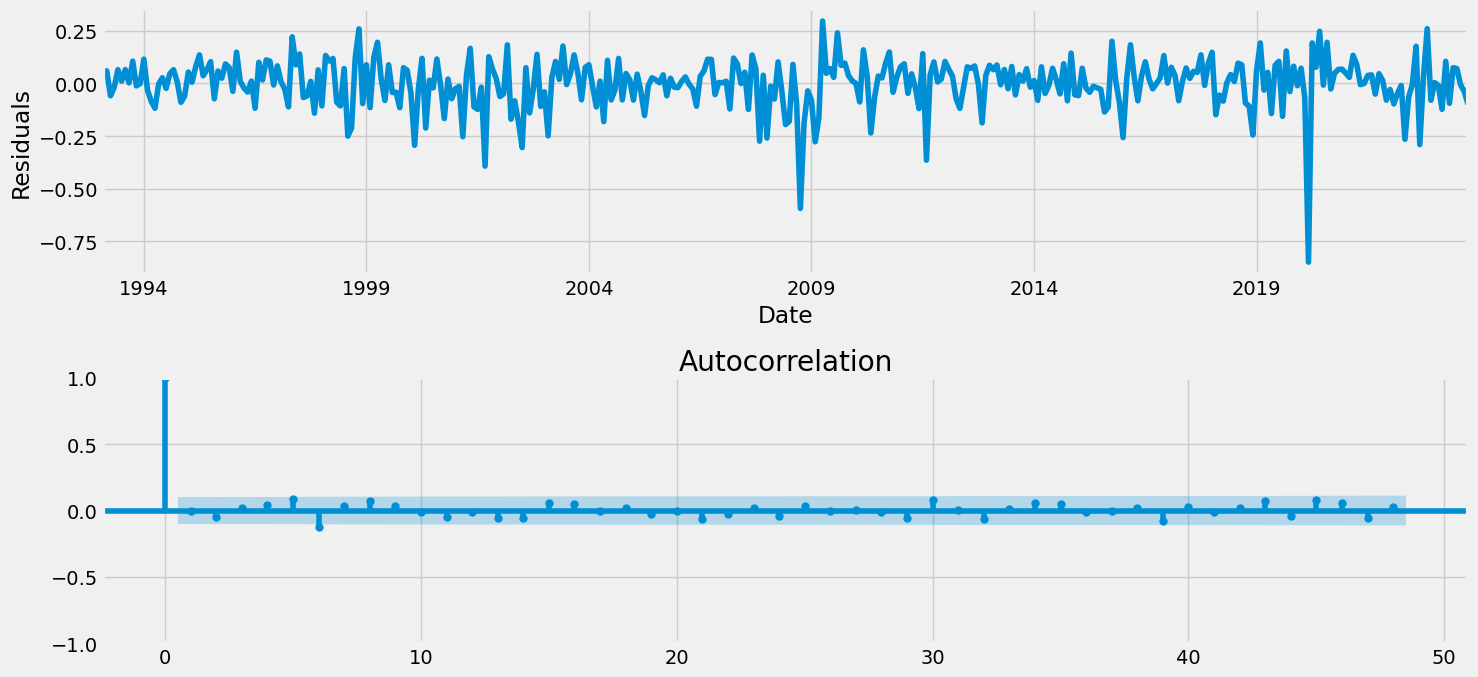

In [65]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [66]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda * y + 1) / lmbda))

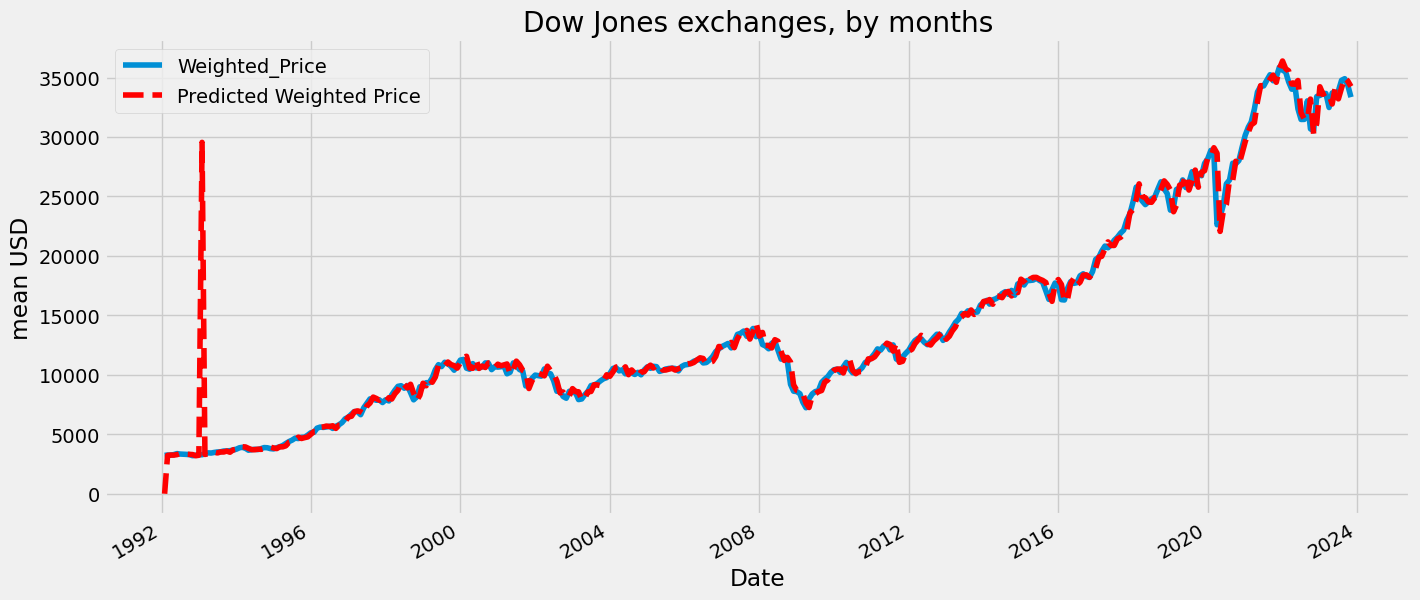

In [67]:
# Prediction
df_month2 = data_month[['Weighted_Price']]
future = pd.DataFrame(data_month['Weighted_Price'])
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted Price')
plt.legend()
plt.title('Dow Jones exchanges, by months')
plt.ylabel('mean USD')
plt.show()

In [68]:
df_month2.head()

Weighted_Price     forecast
Date                                                  
1992-01-31 00:00:00-05:00     3225.652634     1.000000
1992-02-29 00:00:00-05:00     3255.942218  3225.652669
1992-03-31 00:00:00-05:00     3248.054090  3255.942218
1992-04-30 00:00:00-04:00     3291.045545  3248.054090
1992-05-31 00:00:00-04:00     3376.756697  3291.045545

In [69]:
df_month = pd.DataFrame(df_month2, index=pd.to_datetime(df_month2.index))

# Add a new column named 'New_Column' with values equal to the index
df_month['Date'] = df_month.index

# Display the updated DataFrame
arima = df_month[['forecast', 'Date']] 

In [70]:
final_data = pd.DataFrame(final_data)
final_data['Date'] = pd.to_datetime(final_data['Date'])

# Set "Date" column as the index and remove the column
final_data.set_index('Date', inplace=True)


In [72]:
arima = pd.DataFrame(arima)
arima['Date'] = pd.to_datetime(arima['Date'])

# Set "Date" column as the index and remove the column
arima.set_index('Date', inplace=True)


KeyError: 'Date'

In [73]:
merged_data = pd.merge(final_data, arima, on='Date', how='inner')


In [74]:
merged_data.rename(columns={'Forecast': 'Arima'}, inplace=True)

In [83]:
merged_data.head()

Weighted_Price          lstm       xgboost  \
Date                                                                    
2020-01-31 00:00:00-05:00    28461.533203  26819.654297  25268.117188   
2020-01-31 00:00:00-05:00    28461.533203  26819.654297  25268.117188   
2020-03-31 00:00:00-04:00    22075.037891  21185.599609  25226.679688   
2020-03-31 00:00:00-04:00    22075.037891  21185.599609  25226.679688   
2020-04-30 00:00:00-04:00    24409.896484  23345.806641  25498.115234   

                               forecast  
Date                                     
2020-01-31 00:00:00-05:00  28309.768363  
2020-01-31 00:00:00-05:00  28309.768363  
2020-03-31 00:00:00-04:00  28628.914529  
2020-03-31 00:00:00-04:00  28628.914529  
2020-04-30 00:00:00-04:00  22060.143987

In [84]:
merged_data['Date'] = merged_data.index

In [85]:
merged_data.head()

Weighted_Price          lstm       xgboost  \
Date                                                                    
2020-01-31 00:00:00-05:00    28461.533203  26819.654297  25268.117188   
2020-01-31 00:00:00-05:00    28461.533203  26819.654297  25268.117188   
2020-03-31 00:00:00-04:00    22075.037891  21185.599609  25226.679688   
2020-03-31 00:00:00-04:00    22075.037891  21185.599609  25226.679688   
2020-04-30 00:00:00-04:00    24409.896484  23345.806641  25498.115234   

                               forecast                      Date  
Date                                                               
2020-01-31 00:00:00-05:00  28309.768363 2020-01-31 00:00:00-05:00  
2020-01-31 00:00:00-05:00  28309.768363 2020-01-31 00:00:00-05:00  
2020-03-31 00:00:00-04:00  28628.914529 2020-03-31 00:00:00-04:00  
2020-03-31 00:00:00-04:00  28628.914529 2020-03-31 00:00:00-04:00  
2020-04-30 00:00:00-04:00  22060.143987 2020-04-30 00:00:00-04:00

In [101]:
# Assuming 'Date' is in datetime format, if not, convert it using pd.to_datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Filter data between January 1, 2020, and October 31, 2023
filtered_data = merged_data[(merged_data['Date'] >= split_date) & (merged_data['Date'] <= end_date)]

# Now, create a plot with the filtered data
fig = go.Figure()

fig.add_trace(go.Scatter(x=filtered_data['Date'], y=filtered_data['Weighted_Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=filtered_data['Date'], y=filtered_data['xgboost'], mode='lines', name='XGBoost'))
fig.add_trace(go.Scatter(x=filtered_data['Date'], y=filtered_data['lstm'], mode='lines', name='LSTM'))
fig.add_trace(go.Scatter(x=filtered_data['Date'], y=filtered_data['forecast'], mode='lines', name='Arima'))

# Update layout if needed
fig.update_layout(title='Final comparison chart',
                  xaxis_title='Date',
                  yaxis_title='USD $',
                 xaxis=dict(
        range=[filtered_data['Date'].min(), filtered_data['Date'].max()],
#         tickmode='linear',
#         dtick='M1',  # Set the tick interval to 1 month
#         tickformat='%Y-%m'  # Format the tick labels as year-month
    ))

# Show the figure
fig.show()
